# Residential Heat Pump Case Study 2: Low-Cost Hybrid Heating in a Toronto Home
Created: 11/2021  
By: Erik Janssen, Analyst   
Sustainable Technologies Evaluation Program (STEP)  
Toronto and Region Conservation Authority (TRCA)  

## 1 Introduction
This Jupyter Notebook was used to analyze the changes in utility consumption pre- and post-retrofit for the hybrid heating  system analyzed in the accompanying case study. The basic process of the analysis is:

1) Import utility data pre- and post-retrofit.  

2) Estimate current utility rates.

3) Create a linear regression model of the pre-retrofit data as a function of heating degree days (HDDs). This is a baseline against which post-retrofit utility consumption is compared.  

4) Adjust the baseline as required to ensure a fair comparison with actual post-retrofit data.  

5) Estimate the fraction of utility savings from hybrid heating specifically if more than one measure was implemented.  

6) Ensure that the utility impacts attributed to the hybrid heating system is reasonable by calculating the average COP from the gas savings and electricity increase. Compare the calculated average COP against a temperature-weighted COP calculated from manufacturer data (i.e. an expected COP). The COP calculated from the utility data should be lower than that expected based on the manufacturer data. Note COP was not explicitly monitoried, this is just to ensure that it is reasonable to attribute a certain gas savings to the ASHP based on how much electricity it consumed.

7) Calculate other parameters like cost and carbon savings, and perform any other calculations as required.

8) Consider utility implications for carbon pricing schedule looking out to 2030.

## 2 Libraries

In [11]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import datetime

In [12]:
# Set some basic parameters for plotting and visualizing data
font = {'size'   : 16}
plt.rc('font', **font)
step_blue = "#00a3af"
step_gold = "#f8a81d"
pd.set_option('display.max_columns', None)

## 3 Import Baseline and Post-Retrofit Utility Data

Gas consumption data post-retrofit was obtained by inspection of utility bills. Enbridge takes actual meter readings on a bimonthly basis (normally). When an actual reading did not take place for a given month, gas consumption is estimated based on previous usage. The gas bill indicates whether or not the meter reading is actual or estimated. Gas consumption was determined using the actual meter readings. These are shown below. Heat pump was installed and comissioned on October 8th/2020. Note that for the actual meter reading on January 1st 2021, the bill the reading only spanned one month of consumption instead of two. This was the same for the reading taken on April 4th, 2021.

In [13]:
# Import gas meter readings post retrofit
pd.read_csv("Meter Readings.csv", parse_dates=['Date'])

,Date,Meter Reading
0,2020-10-21,17645
1,2020-12-19,17718
2,2021-01-17,17768
3,2021-03-17,18028
4,2021-04-20,18054
5,2021-06-20,18102
6,2021-08-20,18139


In [14]:
# Import consumption data based on meter readings
gas_post = pd.read_csv("gas_data_am.csv", parse_dates=['To','From'])
gas_post

,From,To,m3
0,2020-10-21,2020-12-19,73
1,2020-12-19,2021-01-17,50
2,2021-01-17,2021-03-17,260
3,2021-03-17,2021-04-20,26
4,2021-04-20,2021-06-20,48
5,2021-06-20,2021-08-20,37


The pre-retrofit gas data was obtained from the Enbridge homeowner portal. Data from 2018 to 2019 was used. This is because the data from 2019-2020 included impacts from several behavioural changes that were not sustainable for the homeowner and did not continue into 2020-2021. Note that the distinction between actual/estimated bills does not matter for the pre-retrofit data. The estimates are good indicators of consumption and when they are off, it is corrected for properly in the subsequent bill. The research team observed that post-retrofit, when the estimates are significantly off because of the retrofit, the data downloadable from the Enbridge portal may not be reliable because credits, reversals, or other line items may be omitted. That's why the analysis determined actual post-retrofit gas consumption from the actual meter readings. 

In [15]:
# Import the pre-retrofit data
gas_pre = pd.read_csv("pre_gas_data_am.csv", parse_dates=['To','From'])
gas_pre

,From,To,m3
0,2018-08-22,2018-09-20,48
1,2018-09-21,2018-10-19,27
2,2018-10-20,2018-11-20,243
3,2018-11-21,2018-12-20,228
4,2018-12-21,2019-01-21,372
5,2019-01-22,2019-02-21,302
6,2019-02-22,2019-03-20,302
7,2019-03-21,2019-04-20,98
8,2019-04-21,2019-05-21,130
9,2019-05-22,2019-06-18,44


It's not straightforward to directy visulize pre- and post-retrofit gas consumption because pre-retrofit data is monthly and post-retrofit data is mostly bi-monthly. It is still worthwhile to just look at total consumption. But note that is has not been normalized for weather.

In [16]:
# Total gas consumption pre-retrofit for for October 20th 2018 to June 18th 2019 
total_gas_pre = gas_pre.loc[(gas_pre.index > 1) & (gas_pre.index < 10)].m3.sum()
total_gas_pre

1719

In [17]:
# Total gas consumption post-retrofit for for October 21st 2020 to June 20th 2021
total_gas_post = gas_post.loc[gas_post.index < 5].m3.sum()
total_gas_post

457

In [18]:
# Reduction in gas usage (%) - again not yet weather normalized
(1-total_gas_post/total_gas_pre)*100

73.41477603257708

Gas consumption for October to June on the total bill was reduced by 73%. Now look at electricity data. It was obtained from the Toronto Hydro online portal.

In [19]:
# Import electricity data 
elec = pd.read_csv("elec_data_am.csv",parse_dates=['From','To'])
elec

,From,To,kWh,Cost
0,2018-09-01,2018-09-30,823.00,121.20
1,2018-10-01,2018-10-31,715.00,107.94
2,2018-11-01,2018-11-30,1128.00,160.00
3,2018-12-01,2018-12-31,1157.54,122.93
4,2019-01-01,2019-01-31,994.47,181.38
5,2019-02-01,2019-02-28,1066.43,143.74
6,2019-03-01,2019-03-31,852.11,142.86
7,2019-04-01,2019-04-30,777.22,123.06
8,2019-05-01,2019-05-31,763.57,145.31
9,2019-06-01,2019-06-30,969.46,109.76


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


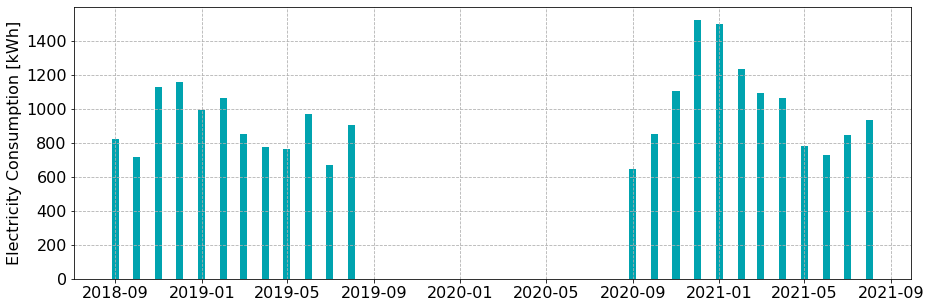

In [20]:
#Visualize
plt.figure(figsize=(15,5))
plt.bar(elec.From,elec.kWh, width = 10, align = 'center', color = step_blue)
plt.ylabel('Electricity Consumption [kWh]')
plt.grid(ls='--')

In [21]:
# Quickly compare electricity consumption pre- and post- for Nov 1st 2020 to June 30th 2021
# Note that the ovelap of the gas and electricity data is off by 10 days
# This small relative to the overall 8-month period being evaluated
total_elec_pre = elec.loc[(elec.index > 1) & (elec.index < 10)].kWh.sum()
total_elec_pre

7708.800000000001

In [22]:
total_elec_post = elec.loc[(elec.index > 13) & (elec.index < 22)].kWh.sum()
total_elec_post

9029.0

In [23]:
# Increase in electricitt usage (%)
(total_elec_post/total_elec_pre-1)*100

17.125882108758805

Initial inspection of gas reduction is substantial, but note that the data still needs to be corrected for weather. Similarly, the electrical increase must also be corrected for a reduction in electric vehicle usage due to COVID-19.

## 4 Import Heating and Cooling Degree Day Data
It is helpful to have a look at weather normalized utility data. We can normalize using HDDs. Weather data for toronto has been gathered from weatherstats.ca which is essentially just a way of accessing Environment Canada data.

In [24]:
# Import hourly weather data file for Toronto and calculate HDDs
# Assumed building balance point of 14 oC because this agreed best with the consumption data
toronto_weather = pd.read_csv("weatherstats_toronto_hourly.csv",parse_dates=True, infer_datetime_format=True)
toronto_weather.date_time_local = [datetime.datetime.strptime(x,'%m/%d/%Y %H:%M') for x in toronto_weather.date_time_local]
toronto_weather = toronto_weather[['date_time_local','temperature']]
toronto_weather['HDDs'] = [(14 - x)*(1/24) if (x < 14) else 0 for x in toronto_weather.temperature] 
toronto_weather.index = toronto_weather.date_time_local
del toronto_weather['date_time_local']
toronto_weather.head()

,temperature,HDDs
date_time_local,,
2021-07-02 08:00:00,18.0,0.0
2021-07-02 07:00:00,16.8,0.0
2021-07-02 06:00:00,16.4,0.0
2021-07-02 05:00:00,16.4,0.0
2021-07-02 04:00:00,16.3,0.0


## 5 Utility Rates and Emission Factors
### 5.1 Natural Gas Rate
The marginal cost of natural gas was estimated using the Ontatio Energy Board (OEB) bill calculator, available at: https://www.oeb.ca/rates-and-your-bill/bill-calculator. Two sample bills were calculated in November 2021 for an Enbridge service area, one for 100 m3 consumption and one for 200 m3. These are shown below. 

![GasBills3.png](GasBills3.png)

The difference in cost between the two bills is 39.3 dollars - for a difference in consumption of 100 m$^{3}$. It follows that the marginal rate for gas was estimated at 0.393 dollars per m3. At the end of 2020 the Federal Government announced a new cabron pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15 dollars per tonne annually to reach 170 dollars by 2030. It will close to double the current rate by 2030. This has significant implications for hybrid system and it evaluated at the end of this notebook.


In [25]:
# Define gas rate
gas_rate = 0.393 # $/m3

### 5.2 Electricity Rate 
The current marginal electricity rates were also calculated using the OEB bill calculator. Six bills were calculated in total. Each bill assumed that electricity was consumed entirely in only one time-of-use (TOU) bracket. For each TOU bracket a 500 kWh and a 600 kWh was calculated. The difference between the two bills was used to calculated the marginal electricity rate for the TOU. This kind of approach was necessary to properly capture all marginal costs, and is helpful because it is straightforward and electricity pricing structures can be complex with mutiple line items. Bills were calculated in November 2021.

The results for peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is dollars 18.8, leading to marginal peak electricity cost estimate of 0.188 dollars per kWh.
![peak_elec.png](peak_elec.png)

The results for mid-peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is 13.2 dollars, leading to marginal peak electricity cost estimate of 0.131 dollars per kWh.
![mid_elec.png](mid_elec.png)

The results for off-peak electricity are shown below - with 500 kWh bill on the left an 600 kWh on the right. The difference between the two bills is 10.1 dollars, leading to marginal peak electricity cost estimate of  0.101 $\$$/kWh.
![off_elec.png](off_elec.png)

Previous analysis (https://sustainabletechnologies.ca/app/uploads/2021/05/DualFuelAnalysis052021.pdf) estimated that 66% of the heating load occurs in an off-peak TOU and the remained is roughly split between mid-peak and on-peak. For simplicity, the analysis looked at the impacts on total electricity consumption only - with the total rate weighted to the percentages above.

In [26]:
# Define elec rates
elec_rate = 0.66*0.101 + 0.132*(0.33/2) + 0.188*(0.33/2)

print("The gas rate is " + str(gas_rate) + ' dollars per cubic meter.')
print("The electricity rate for the heat pump is " + str(elec_rate)[:5] + ' dollars per kWh.')

The gas rate is 0.393 dollars per cubic meter.
The electricity rate for the heat pump is 0.119 dollars per kWh.


The emission factor for electricity was estimated at 0.030 kg equivalent CO2 per kWh. The emission factor for natural gas combustion was assumed at 1.89 kg equivalent CO2 per cubic metre. Values are from the 2021 Canadian National Inventory Report.

In [27]:
# Define emission factor assumptions
EF_elec = 0.030 # kg CO2e per kWh assuming an annual emission factor of 0.030 according to 2021 NIR report
EF_gas = 1.89 # in units kg CO2e per m3

## 6 Calculate HDDs and Define Regression Models of Utility Consumption
We can now add heating degree-days (HDDs) to the utility consumption dataframes. HDDs are needed to account for differences in weather between the pre- and post-retrofit period. These differences are accounted for by creating a linear regression model of utility consumption pre-retrofit, that plots consumption as a function of HDDs. That model can then be applied to the post-retrofit HDD data and compared against the actual post-retrofit consumption.

## 6.1 Gas Consumption

In [28]:
# Function that determines total HDDs in a given window of time
def HDD_total(start_date,end_date):
    temp_df = toronto_weather.loc[(toronto_weather.index>start_date)&(toronto_weather.index<end_date)]
    total_HDDs = temp_df.HDDs.sum()
    return {'HDDs':total_HDDs}

In [29]:
# Add HDDs to pre-retrofit gas dataframe
gas_pre['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(gas_pre.From,gas_pre.To)]
gas_pre

,From,To,m3,HDDs
0,2018-08-22,2018-09-20,48,1.891667
1,2018-09-21,2018-10-19,27,80.729167
2,2018-10-20,2018-11-20,243,316.862500
3,2018-11-21,2018-12-20,228,406.637500
4,2018-12-21,2019-01-21,372,522.316667
5,2019-01-22,2019-02-21,302,592.379167
6,2019-02-22,2019-03-20,302,455.900000
7,2019-03-21,2019-04-20,98,290.358333
8,2019-04-21,2019-05-21,130,148.000000
9,2019-05-22,2019-06-18,44,20.887500


In [30]:
# Add HDDs to post-retrofit gas dataframe
gas_post['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(gas_post.From,gas_post.To)]
gas_post

,From,To,m3,HDDs
0,2020-10-21,2020-12-19,73,572.937500
1,2020-12-19,2021-01-17,50,409.191667
2,2021-01-17,2021-03-17,260,1034.358333
3,2021-03-17,2021-04-20,26,221.920833
4,2021-04-20,2021-06-20,48,170.295833
5,2021-06-20,2021-08-20,37,2.104167


We can now visualize pre- and post-retrofit gas consumption. Note that the comparison is still not completely fair though because the baseline gas consumption (from DHW) is greater for 2-month data intervals (i.e. post-retrofit) than it would be for 1-month intervals (pre-retrofit).

Text(0.5, 0, 'HDDs')

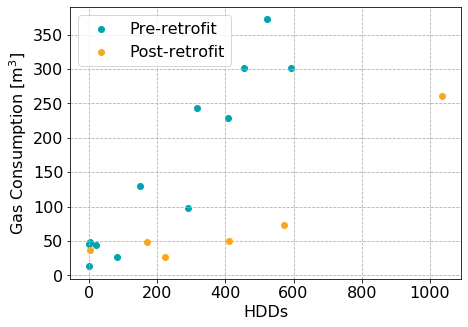

In [31]:
# Visualize it
plt.figure(figsize=(7,5))
plt.scatter(gas_pre.HDDs,gas_pre.m3, label = 'Pre-retrofit', color = step_blue)
plt.grid(ls='--')
plt.ylabel('Gas Consumption [m$^{3}$]')
plt.scatter(gas_post.HDDs,gas_post.m3, label = 'Post-retrofit', color = step_gold)
plt.legend(loc = 2)
plt.xlabel('HDDs')

We now need to make a linear regression model of pre-retrofit gas consumption to use it as a baseline. We actually need two models. One model for a 1-month interval, and one for a 2-month interval. This is because the post-retrofit data has both 1- and 2-month intervals. The slope of the models is the same. The difference would be in the intercept (which is the gas consumption from DHW). 

In [32]:
# Calculate regression line for pre-retrofit data to create a baseline model
x = np.array(gas_pre.HDDs).reshape((-1, 1))
y = np.array(gas_pre.m3)
pre_model_gas = LinearRegression()
pre_model_gas.fit(x, y)
pre_model_gas_r_sq = pre_model_gas.score(x, y)
print('coefficient of determination:', pre_model_gas_r_sq)
print('intercept:', pre_model_gas.intercept_)
print('slope:', pre_model_gas.coef_)

coefficient of determination: 0.8888692945239751
intercept: 25.996549052346865
slope: [0.54337517]


In [33]:
# Define monthly model pre-retrofit for gas
def pre_model_gas_month(HDD):
    m3 = pre_model_gas.coef_[0]*HDD + pre_model_gas.intercept_
    return m3

In [34]:
# Add to dataframe
gas_pre['Modelled'] = [pre_model_gas_month(x) for x in gas_pre.HDDs]
gas_pre

,From,To,m3,HDDs,Modelled
0,2018-08-22,2018-09-20,48,1.891667,27.024434
1,2018-09-21,2018-10-19,27,80.729167,69.862774
2,2018-10-20,2018-11-20,243,316.862500,198.171763
3,2018-11-21,2018-12-20,228,406.637500,246.953269
4,2018-12-21,2019-01-21,372,522.316667,309.810456
5,2019-01-22,2019-02-21,302,592.379167,347.880679
6,2019-02-22,2019-03-20,302,455.900000,273.721288
7,2019-03-21,2019-04-20,98,290.358333,183.770057
8,2019-04-21,2019-05-21,130,148.000000,106.416074
9,2019-05-22,2019-06-18,44,20.887500,37.346298


Text(0.5, 0, 'HDDs')

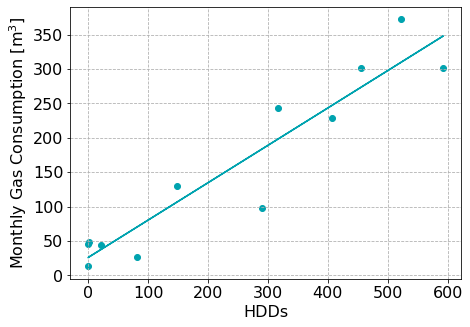

In [35]:
# Visualize it
plt.figure(figsize=(7,5))
plt.scatter(gas_pre.HDDs,gas_pre.m3, color = step_blue)
plt.plot(gas_pre.HDDs,gas_pre.Modelled, color = step_blue)
plt.grid(ls='--')
plt.ylabel('Monthly Gas Consumption [m$^{3}$]')
plt.xlabel('HDDs')

In [36]:
# Define bimonthly model pre-retrofit for gas
def pre_model_gas_2month(HDD):
    m3 = pre_model_gas.coef_[0]*HDD + 2*pre_model_gas.intercept_
    return m3

In [37]:
# Use models to estimate baseline gas consumption for post-retrofit data
gas_post['Baseline_m3'] = [pre_model_gas_month(x) if (y == 1)|(y == 3) else pre_model_gas_2month(x) for x,y in zip(gas_post.HDDs, gas_post.index)]
gas_post

,From,To,m3,HDDs,Baseline_m3
0,2020-10-21,2020-12-19,73,572.937500,363.313109
1,2020-12-19,2021-01-17,50,409.191667,248.341140
2,2021-01-17,2021-03-17,260,1034.358333,614.037732
3,2021-03-17,2021-04-20,26,221.920833,146.582819
4,2021-04-20,2021-06-20,48,170.295833,144.527625
5,2021-06-20,2021-08-20,37,2.104167,53.136450


In [38]:
# Total gas consumption post-retrofit
tot_gas_post = gas_post.loc[gas_post.index < 5].m3.sum()
tot_gas_post

457

In [39]:
# Baseline gas consumption - i.e. what it would have been without the retrofit
tot_gas_post_baseline = gas_post.loc[gas_post.index <5].Baseline_m3.sum()
tot_gas_post_baseline

1516.8024254290376

In [40]:
# Reduction in gas consumption in %
(1-tot_gas_post/tot_gas_post_baseline)*100

69.87082876856987

In [41]:
# Gas savings in m3
gas_savings = tot_gas_post_baseline - tot_gas_post
gas_savings

1059.8024254290376

Need to take into account the change in hot water usage. The homeowner mentioned the following changes (direct quote):  
"  
1) I changed from 15 minutes showers to navy showers (2 minutes where you get wet, shut off & lather, and then rinse)  
2) My wife stopped taking baths, which she would do a couple times a week especially during colder weather (oversized tub,  so significant volume of water)  
3) Using less hot water when washing dishes by hand, and when using the sink (e.g. wash hands with very low volume)   
"  
  
1) and 3) could be taken account by looking at the gas consumption during Summer 2018 & 2019 vs. Summer 2021. Section 3 showed that total gas consumption from April 20th/2021 to August 20th/2021 was 85 m3 - or 21.5 m3 per month. It also showed August 22nd/2018 to October 18th/2018 had a total gas consumption of 75 m3, and May 22nd/2019 to July 18th had a gas consumption of 90 m3. This is 41.25 m3/month for the baseline period. The change is ~20 m3 per month and it is from (1) and (3). Ignored summer months with strangely low readings. The family does have a cottage and may not have actually been in the home much when gas consumption was very low during summer. Note the household also has 2 children that take 10-15 minute hot showers and that did not change pre- and post-retrofit.

Estimating the impacts of no baths is more challenging. It is done below.


In [42]:
# Estimate gas consumption per bath
vol = 200 # water volume in L for a large tub - homeowner noted tub was large
dens = 1 # water density kg/L
c = 4200 # specific heat in Joule per kg oC
t_tap = 10 # average inlet water temperature from the city
t_b = 40 # bath temperature
eff = 0.85 # efficiency loss due to insulated hot water pipes in home and efficiency of on-demand heater
gas_energy = 0.038*10**9 # GJ per m3

gas_per_bath = vol * dens * c *(t_b - t_tap) * (1/eff) * (1/gas_energy)
gas_per_bath

0.7801857585139319

This is very approximate but it is estimated that 1 bath is 1 m3 of gas (rounding up). Baths were taken on a biweekly basis assumed over the 8-month period (35 weeks).

In [43]:
bath_correction = 1 * 2 * 35 # m3 savings from not taking baths during 2020/2021 for 8-month period
shower_correction = 20 * 8 # m3 savings from navy showers and overall reduced hot water usage
total_gas_corr = bath_correction + shower_correction
total_gas_corr

230

In [44]:
# Gas savings from hybrid system
hybrid_gas_sav = gas_savings - total_gas_corr
hybrid_gas_sav

829.8024254290376

In [45]:
# Percentage gas savings from hybrid system in reference to total gas bill
hybrid_gas_sav/tot_gas_post_baseline

0.5470735090592451

In [46]:
# Percentage reduction in reference to space heating alone
Total_DHW_baseline = bath_correction + 41.25*8 # Estimated baseline gas consumption for DHW; showers + baths
hybrid_gas_sav/(tot_gas_post_baseline - Total_DHW_baseline)

0.7430163174209222

## 6.2 Electricity Consumption

In [47]:
# Add HDDs to dataframe
elec['HDDs'] = [HDD_total(x,y)['HDDs'] for x,y in zip(elec.From,elec.To)]
elec

,From,To,kWh,Cost,HDDs
0,2018-09-01,2018-09-30,823.00,121.20,11.183333
1,2018-10-01,2018-10-31,715.00,107.94,170.912500
2,2018-11-01,2018-11-30,1128.00,160.00,355.770833
3,2018-12-01,2018-12-31,1157.54,122.93,417.787500
4,2019-01-01,2019-01-31,994.47,181.38,602.129167
5,2019-02-01,2019-02-28,1066.43,143.74,479.025000
6,2019-03-01,2019-03-31,852.11,142.86,447.741667
7,2019-04-01,2019-04-30,777.22,123.06,226.300000
8,2019-05-01,2019-05-31,763.57,145.31,95.008333
9,2019-06-01,2019-06-30,969.46,109.76,9.287500


In [48]:
# Define a pre-retrofit dataframe
elec_pre = elec.loc[(elec.index > 1)&(elec.index < 10)]
elec_pre

,From,To,kWh,Cost,HDDs
2,2018-11-01,2018-11-30,1128.00,160.00,355.770833
3,2018-12-01,2018-12-31,1157.54,122.93,417.787500
4,2019-01-01,2019-01-31,994.47,181.38,602.129167
5,2019-02-01,2019-02-28,1066.43,143.74,479.025000
6,2019-03-01,2019-03-31,852.11,142.86,447.741667
7,2019-04-01,2019-04-30,777.22,123.06,226.300000
8,2019-05-01,2019-05-31,763.57,145.31,95.008333
9,2019-06-01,2019-06-30,969.46,109.76,9.287500


In [49]:
# Define a post-retrofit dataframe
elec_post = elec.loc[(elec.index > 13)&(elec.index < 22)]
elec_post

,From,To,kWh,Cost,HDDs
14,2020-11-01,2020-11-30,1105.0,154.68,214.270833
15,2020-12-01,2020-12-31,1523.0,208.71,427.566667
16,2021-01-01,2021-01-31,1497.0,189.72,485.404167
17,2021-02-01,2021-02-28,1234.0,158.23,522.787500
18,2021-03-01,2021-03-31,1093.0,156.40,329.866667
19,2021-04-01,2021-04-30,1063.0,153.62,185.987500
20,2021-05-01,2021-05-31,784.0,126.27,85.900000
21,2021-06-01,2021-06-30,730.0,122.02,3.316667


(0, 1600)

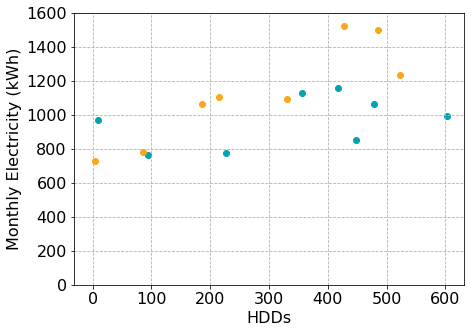

In [50]:
# Visualize results 
plt.figure(figsize = (7,5))
plt.scatter(elec_pre.HDDs,elec_pre.kWh, label = 'Pre-retrofit', color = step_blue)
plt.scatter(elec_post.HDDs,elec_post.kWh, label = 'Post-retrofit', color = step_gold)
plt.grid(ls='--')
plt.xlabel('HDDs')
plt.ylabel('Monthly Electricity (kWh)')
plt.ylim(0,1600)

The data suggests a weak temperature dependence pre-retrofit. There at least 2 sources of the temperature dependence. Firstly, the furnace blower (which could be on the scale of 500W) is going to be operating much more in cold weather. For example, say the furnace operated 10 hours per day on average for the coldest months. This would be 5 kWh per day, or roughly 150 kWh for a month. Secondly, the homeowner commutes to work (48km round trip 5 days per week) with an electric vehicle. He estimates that the efficiency of the vehicle drops from approximately 130 Wh per km in warmer temperatures to 220 Wh per km in very cold temperatures. That is an extra 4.3 kWh per day, and near 100 kWh per month. These two factors explain the large majority of the temperature dependence. Baseline electricity consumption can be represented by a linear regression model.

In [51]:
# Calculate regression line for baseline electricity data
x = np.array(elec_pre.HDDs).reshape((-1, 1))
y = np.array(elec_pre.kWh)
pre_model_elec = LinearRegression()
pre_model_elec.fit(x, y)
pre_model_elec_r_sq = pre_model_elec.score(x, y)
print('coefficient of determination:', pre_model_elec_r_sq)
print('intercept:', pre_model_elec.intercept_)
print('slope:', pre_model_elec.coef_)

coefficient of determination: 0.19760872304765076
intercept: 853.2712994955949
slope: [0.33521187]


The model has a low R2. This means that there are other important factors influencing the variation besides HDDs. With limited data available, it is not possible to take these factors into account.

In [52]:
# Define monthly model pre-retrofit for electricity
def pre_model_elec_month(HDD):
    kWh = pre_model_elec.coef_[0]*HDD + pre_model_elec.intercept_
    return kWh

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0, 1600)

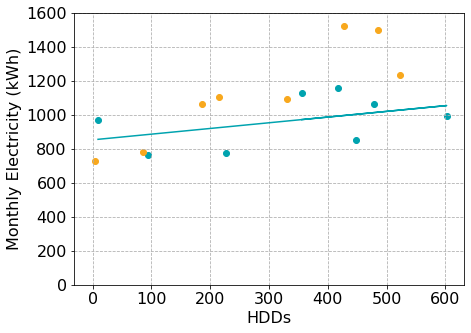

In [53]:
# Visualize model against actual data
elec_pre['Modelled'] = [pre_model_elec_month(x) for x in elec_pre.HDDs]
plt.figure(figsize = (7,5))
plt.scatter(elec_pre.HDDs,elec_pre.kWh, label = 'Pre-retrofit', color = step_blue)
plt.scatter(elec_post.HDDs,elec_post.kWh, label = 'Post-retrofit', color = step_gold)
plt.plot(elec_pre.HDDs,elec_pre.Modelled, color = step_blue)
plt.grid(ls='--')
plt.xlabel('HDDs')
plt.ylabel('Monthly Electricity (kWh)')
plt.ylim(0,1600)

In [54]:
# Use model to add a baseline electricity estimate to the post-retrofit dataframe
elec_post['Baseline_kWh'] = [pre_model_elec_month(x) for x in elec_post.HDDs]
elec_post

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,From,To,kWh,Cost,HDDs,Baseline_kWh
14,2020-11-01,2020-11-30,1105.0,154.68,214.270833,925.097425
15,2020-12-01,2020-12-31,1523.0,208.71,427.566667,996.596720
16,2021-01-01,2021-01-31,1497.0,189.72,485.404167,1015.984536
17,2021-02-01,2021-02-28,1234.0,158.23,522.787500,1028.515873
18,2021-03-01,2021-03-31,1093.0,156.40,329.866667,963.846520
19,2021-04-01,2021-04-30,1063.0,153.62,185.987500,915.616516
20,2021-05-01,2021-05-31,784.0,126.27,85.900000,882.065999
21,2021-06-01,2021-06-30,730.0,122.02,3.316667,854.383086


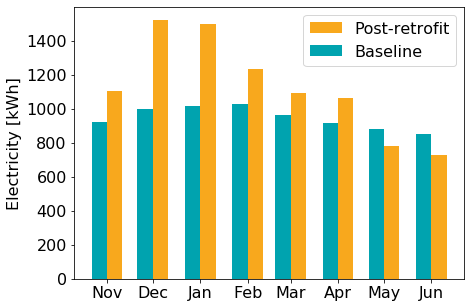

In [55]:
# Visualize as a barplot
# Note that this has not yet taken into account the reduction in EV usage dur to COVID-19
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(elec_post.From,elec_post.kWh,width = 10, align = 'edge', color = step_gold, label = 'Post-retrofit')
ax.bar(elec_post.From,elec_post.Baseline_kWh,width = -10, align = 'edge', color = step_blue, label = 'Baseline')
ax.set_xticklabels(['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])
ax.set_ylabel('Electricity [kWh]')
ax.legend()

In [56]:
# Total electricity consumption post-retrofit 
tot_elec_post = elec_post.kWh.sum()
tot_elec_post

9029.0

In [57]:
# Total estimated baseline electricity - i.e. what it would have been with no heat pump
tot_elec_baseline = elec_post.Baseline_kWh.sum()
tot_elec_baseline

7582.106675207415

In [58]:
# Increase in electricity consumption (%)
100*(tot_elec_post/tot_elec_baseline - 1)

19.08299878612567

In [59]:
# Increase in electricity consumption (kWh)
elec_increase = tot_elec_post - tot_elec_baseline
elec_increase

1446.8933247925852

This needs to be adjusted for the change in EV (Tesla) usage. The homeowner collected data on charging from October 8th/2020 to April 18th/2021 - and it totalled 1,279 kWh. Adjusting to 8 months (to coincide with the other utility data being analyzed) yields 1,618 kWh.

During 2020/2021, the electric vehicle was driven for a commute a total of 20 km per day for 4.5 days per week and 48 weeks per year. This totals to 4,320 km per year - or 2,880 km adjusted to 8 months. The Tesla efficiency is 160 Wh per km in ideal conditions and 220 Wh per km in very cold weather. Assuming an average of 190 Wh per km, the electricity consumption for commuting during the 8-month period post-retrofit is 547 kWh - so the large majority of usage (1,071) kWh is from non-work usage like errands or going to their cottage. 

During 2018/2019 the electric vehicle was used to drive 48 km round trip per day for 48 weeks per year, totalling 11,520 km per year - adjusted to 7,680 km for 8 months. Assuming 190 Wh per km, this is 1,459 kWh. No data on actual consumption is available. The difference in electricity from commuting is therefore 912 kWh. 

The homeowner noted that in 2020/2021 they also drove less for non-commuting activities compared to 2018/2019 due to the pandemic. Their non-commuting activities are a significant portion of their overall EV consumption. Assuming their non-commuting reduced by 30% that would lead to an additional correction of 693 kWh.

In [60]:
corr_non_commute = 1618/(1-0.30) - 1618 # Assuming that 1618 is actually a 30% reduction for non-commuting activities
corr_non_commute

693.4285714285716

In [61]:
# Correct electrical increase
corr = 912 + corr_non_commute
corr

1605.4285714285716

In [62]:
# Corrected baseline
tot_elec_baseline_corr = tot_elec_baseline - corr
tot_elec_baseline_corr

5976.678103778843

In [63]:
# Add correction to increase
elec_increase_corr = tot_elec_post - tot_elec_baseline_corr
elec_increase_corr

3052.3218962211567

In [64]:
# Electricity cost increase
elec_increase_corr * elec_rate

364.63037372257946

## 6.3 Estimate Rough COP to Ensure Results are Reasonable
If you look at the ratio of gas energy savings (adjusted for furnace efficiency) vs. electricity energy increase, then it is a rough estimate of COP and it should fall within a reasonable range. Recall that gas savings is energy that was previous supplied to heat the home. That heat energy is now provided by the heat pump (correcting for the furnace). The previous furnace had an AFUE of 92% but it actual efficiency would likely be lower due its age and other practical considerations.

In [65]:
# Calc rough COP as a check on the data
COP = (hybrid_gas_sav * 0.85 * 10.6) / (elec_increase_corr) # 10.6 is kWh energy per m3; 85% is assume previous furnace efficiency
COP

2.4494532710890446

Heat pump specs are below. I'll calculate a temperature-weighted COP based on this manufacturer data and the temperature during the post-retrofit period. This is done below.

![hp_specs.png](hp_specs.png)

coefficient of determination: 0.9852625129228393
intercept: 2.6594545454545457
slope: [0.07003636]


Text(0.5, 1.0, 'Manufacturer Specs')

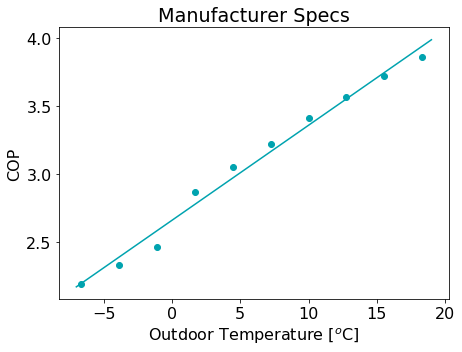

In [66]:
# PLot COP and define model
COP_Temps_F = [65, 60, 55, 50, 45, 40, 35, 30, 25, 20]
COP_Temps_C = [(x-32)*(5/9) for x in COP_Temps_F]
COPs = [3.86, 3.72, 3.57, 3.41, 3.22, 3.05, 2.87, 2.46, 2.33, 2.19]

# Visulualize COP data
plt.figure(figsize = (7,5))
plt.scatter(COP_Temps_C, COPs, color = step_blue)
plt.xlabel('Outdoor Temperature [$^{o}$C]')
plt.ylabel('COP')

# Calculate regression model for COP
x = np.array(COP_Temps_C).reshape((-1, 1))
y = np.array(COPs)
COP_model = LinearRegression()
COP_model.fit(x, y)
COP_model_r_sq = COP_model.score(x, y)
print('coefficient of determination:', COP_model_r_sq)
print('intercept:', COP_model.intercept_)
print('slope:', COP_model.coef_)

# Define COP Function
def COP_func(Temp):
    COP = COP_model.coef_[0] * Temp + COP_model.intercept_
    return COP

# Plot model
x = np.arange(-7,20,1)
y = [COP_func(a) for a in x]
plt.plot(x,y, color = step_blue)    
plt.title('Manufacturer Specs')

In [67]:
# Calculate temperature-weighted COP for post-retrofit period
start = datetime.datetime.strptime('10/21/2020','%m/%d/%Y')
stop = datetime.datetime.strptime('06/20/2021','%m/%d/%Y')
post_weather = toronto_weather.loc[(toronto_weather.index > start)&
                                   (toronto_weather.index < stop)&
                                   (toronto_weather.temperature < 14)&
                                   (toronto_weather.temperature > -6)]
post_weather['COP'] = [COP_func(x) for x in post_weather.temperature]
temp_weighted_COP = post_weather.COP.mean()
temp_weighted_COP

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2.8923894243670563

In [68]:
# Percentage reduction of COP from post-retrofit data against temperature-weighted COP from specs
(1-COP/temp_weighted_COP)*100

15.313849149996106

The estimate of "actual" COP that came out of the analysis, based on the gas savings and electrical increase, was 14% lower than what would be expected based on manufacturer specifications. This is somewhat reasonable since actual operation includes defrost and cycling - both of which will degrade efficiency. More performance degradation from these factors might have been expected.

## 6.3 Net Cost and Carbon Savings



In [69]:
# Net carbon savings
carbon_savings = hybrid_gas_sav * EF_gas - elec_increase_corr * EF_elec
carbon_savings

1476.7569271742464

In [70]:
# Net cost savings from hybrid system
hybrid_gas_sav * gas_rate - elec_increase_corr * elec_rate

-38.51802052896767

In [71]:
# Overall net cost savings
net_cost_savings = gas_savings * gas_rate - elec_increase_corr * elec_rate
net_cost_savings

51.87197947103232

In [72]:
# Create lists for plot
baseline = [tot_gas_post_baseline*gas_rate,tot_elec_baseline_corr*elec_rate]
postretrofit = [tot_gas_post*gas_rate,tot_elec_post*elec_rate]
reduction = [net_cost_savings]

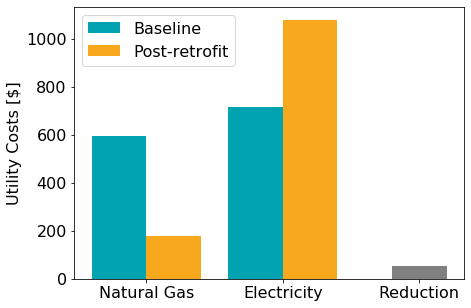

In [73]:
# Plot 
fig, ax = plt.subplots(figsize = (7,5))
ax.bar([1,2], baseline, width = -0.4, align = 'edge', color = step_blue, label = 'Baseline')
ax.bar([1,2], postretrofit, width = 0.4, align = 'edge', color = step_gold, label = 'Post-retrofit')
ax.bar([3],reduction, color = 'grey', width = 0.4)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Natural Gas','Electricity', 'Reduction'])
ax.set_ylabel('Utility Costs [$]')
ax.legend()

Note this plot neglects the fixed monthly customer charge for holding accounts with the utility.

## 7 Annual Utility Costs to 2030

At the end of 2020 the federal government announced a new carbon pricing schedule in their plan titled "A Healthy Environment and A Healthy Economy." Starting in 2023, the federal price on carbon will increase at 15$\$$ per year to reach $\$$170 by 2030. This has significant implications for dual fuel heat pump systems. This is outlined in the dataframe below. It ignores other fluctuations in the cost of natural gas and simply adds additional charges onto the current rate.

In [74]:
# Import carbon charge data
# You can see this aligns with carbon charge data from enbridge
# https://www.enbridgegas.com/residential/my-account/rates/federal-carbon-charge (below)
nat_gas_rate_df = pd.read_csv("nat_gas_carbon_pricing.csv")
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3)
0,2021,40,0.078300
1,2022,50,0.097875
2,2023,65,0.127238
3,2024,80,0.156600
4,2025,95,0.185963
5,2026,110,0.215325
6,2027,125,0.244688
7,2028,140,0.274050
8,2029,155,0.303412
9,2030,170,0.332775


![Enbridge_CC2.png](Enbridge_CC2.png)

In [75]:
# Add cost escalation due to carbon charge
gas_rate_no_carbon_charge = gas_rate - 0.078
nat_gas_rate_df['Gas_Rate'] = [gas_rate_no_carbon_charge + x for x in nat_gas_rate_df['Carbon Charge Natural Gas ($/m3)']]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate
0,2021,40,0.078300,0.393300
1,2022,50,0.097875,0.412875
2,2023,65,0.127238,0.442238
3,2024,80,0.156600,0.471600
4,2025,95,0.185963,0.500962
5,2026,110,0.215325,0.530325
6,2027,125,0.244688,0.559688
7,2028,140,0.274050,0.589050
8,2029,155,0.303412,0.618413
9,2030,170,0.332775,0.647775


In [76]:
# Add electricity cost escalation - 
# Assume 2% per year there has been no recent long-term energy plan to for a better estimate
# Just add it to natural gas data frame
nat_gas_rate_df['Elec_Rate'] = [elec_rate*(1.02)**x for x in nat_gas_rate_df.index]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Elec_Rate
0,2021,40,0.078300,0.393300,0.119460
1,2022,50,0.097875,0.412875,0.121849
2,2023,65,0.127238,0.442238,0.124286
3,2024,80,0.156600,0.471600,0.126772
4,2025,95,0.185963,0.500962,0.129307
5,2026,110,0.215325,0.530325,0.131893
6,2027,125,0.244688,0.559688,0.134531
7,2028,140,0.274050,0.589050,0.137222
8,2029,155,0.303412,0.618413,0.139966
9,2030,170,0.332775,0.647775,0.142766


In [77]:
# Add utility costs
nat_gas_rate_df['Annual_Gas_Savings'] = [hybrid_gas_sav*x for x in nat_gas_rate_df.Gas_Rate]
nat_gas_rate_df['Annual_Elec_Increase'] = [elec_increase_corr*x for x in nat_gas_rate_df.Elec_Rate]
nat_gas_rate_df['Annual_Net_Cost_Change'] = [y - x for x,y in zip(nat_gas_rate_df.Annual_Gas_Savings,nat_gas_rate_df.Annual_Elec_Increase)]
nat_gas_rate_df.head(10)

,Year,Carbon Tax ($/tonne),Carbon Charge Natural Gas ($/m3),Gas_Rate,Elec_Rate,Annual_Gas_Savings,Annual_Elec_Increase,Annual_Net_Cost_Change
0,2021,40,0.078300,0.393300,0.119460,326.361294,364.630374,38.269080
1,2022,50,0.097875,0.412875,0.121849,342.604676,371.922981,29.318305
2,2023,65,0.127238,0.442238,0.124286,366.969750,379.361441,12.391691
3,2024,80,0.156600,0.471600,0.126772,391.334824,386.948670,-4.386154
4,2025,95,0.185963,0.500962,0.129307,415.699898,394.687643,-21.012255
5,2026,110,0.215325,0.530325,0.131893,440.064971,402.581396,-37.483575
6,2027,125,0.244688,0.559688,0.134531,464.430045,410.633024,-53.797021
7,2028,140,0.274050,0.589050,0.137222,488.795119,418.845684,-69.949434
8,2029,155,0.303412,0.618413,0.139966,513.160192,427.222598,-85.937594
9,2030,170,0.332775,0.647775,0.142766,537.525266,435.767050,-101.758216


In [78]:
# Total net cost to 2030
nat_gas_rate_df.Annual_Net_Cost_Change.sum()

-294.34517501973863

Text(0, 0.5, 'Net Annual Utility Cost Change [$]')

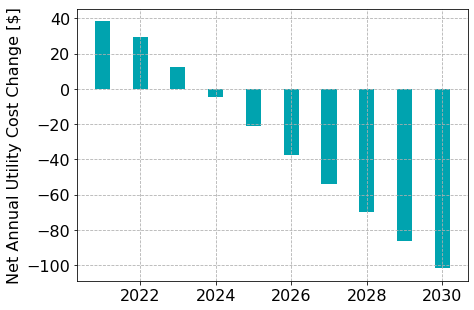

In [79]:
# Visualize
plt.figure(figsize=(7,5))
plt.bar(nat_gas_rate_df.Year,nat_gas_rate_df.Annual_Net_Cost_Change,color=step_blue, align = 'center', width = 0.4)
plt.grid(ls='--')
plt.ylabel('Net Annual Utility Cost Change [$]')

Note the similarity between the predictions of the above plot with the analysis presented in Figure 12 in this STEP report which theoretically evaluated the utility cost savings to 2030. https://sustainabletechnologies.ca/app/uploads/2021/05/DualFuelAnalysis052021.pdf